# Montu Python 
## Astronomical ephemerides for the Ancient World
## Test file: testing Planetary Body routines 

In [1]:
from montu import *
Montu.load_kernels(verbose=False)

from scipy.optimize import newton,minimize_scalar,bisect
%load_ext autoreload
%autoreload 2

## Edition of Class

In [319]:
###############################################################
# Planetary body
###############################################################
PLANETARY_IDS = dict(
    SUN = 10,
    MERCURY = 1,
    VERNUS = 2,
    EARTH = 399,
    MOON = 301,
    MARS = 4,
    JUPITER = 5,
    SATURN = 6,
    URANUS = 7,
    NEPTUNE = 8,
)
PLANETARY_NAMES = {str(v): k for k, v in PLANETARY_IDS.items()}

class PlanetaryBodyx(object):
    """Create a planetary body

    Examples: 
        earth = PlanetaryBody('399')
        mars = PlanetaryBody('mars')
        jupiter = PlanetaryBody('JUPITER')

    """

    @lru_cache()
    def __new__(cls,id):
        """This method is intended to avoid creating a new object with the same id
        Instead this method create a clone of the previously created object.
        """
        return super().__new__(cls)

    def __init__(self,body):

        # Names
        self.body = body.upper()
        if self.body in PLANETARY_IDS.keys():
            self.name = self.body.lower()
            self.id = str(PLANETARY_IDS[self.body])
        elif self.body in PLANETARY_NAMES.keys():
            self.id = str(self.body)
            self.name = PLANETARY_NAMES[self.id].lower()
        else:
            raise ValueError(f"Planet '{self.body}' not recognized, check variable PLANETARY_NAMES")
        self.capital = self.name[0].upper() + self.name[1:]

        # IAU frame of planet
        self.frameplanet = f'IAU_{self.name.upper()}'

        # Obtain object properties
        try:
            n,rs=spy.bodvrd(self.id,'RADII',3)
        except:
            n,rs=spy.bodvrd(self.id+'99','RADII',3)
        self.Re=rs[0]
        self.Rt=rs[1]
        self.Rp=rs[2]
        self.f=(self.Re-self.Rp)/self.Re

        # Create object from PyPlanet
        exec(f'self.pyplanet = pyplanets_{self.capital}')

        # Create Horizons object
        self.query_horizons = astropy_Horizons(id='4')

        # No predicted yet
        self.predict = False

    def calculate_sky_position(self,mtime=None,site=None,method='Horizons',
                               store=None,verbose=True):
        """Calculate position of a planet 

        Parameters:
            mtime: MonTime:
                Time when the position of the planet will be calculated.

            site: Site:
                Observing site w.r.t. position of the planet will be calculated.

            method:
                'Horizons': use astroquery.
                'SPICE': use SPICE and kernels.
                'VSOP87': use VSOP87 analytical theory.
                'all': all methods
        """
        self.data = {
            'datetime64':[mtime.obj_datetime64],
            'datetime_proleptic':[mtime.obj_datetime],
            'datetime_mixed':[mtime.obj_datetimemix],
            'tt':[mtime.tt]
            }
        if store:
            if 'df' not in self.__dict__.keys():
                self.df = pd.DataFrame()
        
        if site is None:
            raise ValueError("No site selected")

        # Update orientation of site
        Montu.vprint(verbose,f"Computing position of body '{self.name}' at epoch: jtd = {mtime.jtd} ")
        if mtime.tt != site.epoch.tt:
            Montu.vprint(verbose,f"Updating orientation of site (old time {site.epoch.datespice}, new time {mtime.datespice})")
            site.update_site(mtime)

        # Storing epoch
        self.epoch = mtime
            
        # Check if all methods are asked
        all_methods = True if method == 'all' else False

        # Check compute
        compute = False

        # Compute absolute coordinates (RA & Dec) at J2000 and epoch
        if method == 'Horizons' or all_methods:            

            # Using Horizons database
            Montu.vprint(verbose,"Method 'Horizons':")

            # Query ephemerides
            self.query_horizons.location = site.location
            self.query_horizons.epochs = self.epoch.jed # Julian Day as it was UTC
            self.ephemerides = self.query_horizons.ephemerides().to_pandas()
            ephemerides = self.ephemerides.loc[0]

            # Sky coordinates in J2000
            self.RAJ2000 = float(ephemerides.RA/15)
            self.DecJ2000 = float(ephemerides.DEC)
            
            # Ecliptic coordinates in J2000
            uJ2000 = np.array([np.cos(self.DecJ2000*DEG)*np.cos(15*self.RAJ2000*DEG),
                               np.cos(self.DecJ2000*DEG)*np.sin(15*self.RAJ2000*DEG),
                               np.sin(self.DecJ2000*DEG)])
            ecJ2000 = spy.mxv(M_J2000_ECLIPJ2000,uJ2000)
            r,LonJ2000,LatJ2000 = spy.recrad(ecJ2000)
            self.LonJ2000 = LonJ2000*RAD
            self.LatJ2000 = LatJ2000*RAD

            # Sky coordinates @ Epoch
            self.RAEpoch = float(ephemerides.RA_app/15)
            self.DecEpoch = float(ephemerides.DEC_app)
            self.LonEpoch = float(ephemerides.ObsEclLon)
            self.LatEpoch = float(ephemerides.ObsEclLat)
            
            # Apparent coordinates @ site
            self.az = float(ephemerides.AZ)
            self.el = float(ephemerides.EL)
            
            # Compute hour angle
            self.HA = np.mod(np.arctan2(-np.sin(self.az*DEG)*np.cos(self.el*DEG)/np.cos(self.DecEpoch*DEG),
                                        (np.sin(self.el*DEG) - np.sin(self.DecEpoch*DEG)*np.sin(site.lat*DEG)) / \
                                        (np.cos(self.DecEpoch*DEG) * np.cos(site.lat*DEG)))*RAD/15,24)
            
            # Sidereal time
            self.tsa = np.mod(self.RAEpoch + self.HA,24)

            self._store_data('Horizons')
            Montu.vprint(verbose,"\tCoordinates @ J2000: ")
            Montu.vprint(verbose,"\t\tEquatorial:",Montu.dec2hex(self.RAJ2000),Montu.dec2hex(self.DecJ2000))
            Montu.vprint(verbose,"\t\tEcliptic:",Montu.dec2hex(self.LonJ2000),Montu.dec2hex(self.LatJ2000))
            Montu.vprint(verbose,f"\tCoordinates @ Epoch : ")
            Montu.vprint(verbose,"\t\tEquatorial:",Montu.dec2hex(self.RAEpoch),Montu.dec2hex(self.DecEpoch))
            Montu.vprint(verbose,"\t\tEcliptic:",Montu.dec2hex(self.LonEpoch),Montu.dec2hex(self.LatEpoch))
            Montu.vprint(verbose,f"\tLocal true sidereal time: ",Montu.dec2hex(self.tsa))
            Montu.vprint(verbose,f"\tHour angle @ Epoch: ",Montu.dec2hex(self.HA))
            Montu.vprint(verbose,f"\tLocal coordinates @ Epoch: ",Montu.dec2hex(self.az),Montu.dec2hex(self.el))

            compute = True

        if method == 'VSOP87' or all_methods:

            # Using VSOP87 semianalytical model implemented in PyEphem
            Montu.vprint(verbose,"Method 'VSOP87':")

            # Prepare object
            self.pyephem_planet = eval(f'pyephem.{self.capital}()')

            # Define observer
            self.pyephem_site = pyephem.Observer()
            self.pyephem_site.date = self.epoch.obj_pyephem
            self.pyephem_site.lat = f'{site.lat}'
            self.pyephem_site.lon = f'{site.lon}'
            self.pyephem_site.elevation = site.elevation
            self.pyephem_site.temp = site.temperature
            self.pyephem_site.pressure = site.pressure
            
            # Compute ephemerides
            self.pyephem_planet.compute(self.pyephem_site)
            self.RAEpoch = float(self.pyephem_planet.ra)*RAD/15
            self.DecEpoch = float(self.pyephem_planet.dec)*RAD
   
            # Ecliptic coordinates at Epoch
            uEpoch = np.array([np.cos(self.DecEpoch*DEG)*np.cos(15*self.RAEpoch*DEG),
                               np.cos(self.DecEpoch*DEG)*np.sin(15*self.RAEpoch*DEG),
                               np.sin(self.DecEpoch*DEG)])
            ecEpoch = spy.mxv(site.epoch.M_equatorial_ecliptic,uEpoch)
            r,LonEpoch,LatEpoch = spy.recrad(ecEpoch)
            self.LonEpoch = LonEpoch*RAD
            self.LatEpoch = LatEpoch*RAD
            
            # Compute elevation and azimuth
            self.el = self.pyephem_planet.alt*RAD
            self.az = self.pyephem_planet.az*RAD

            # Precess towards J2000
            self.RAJ2000,self.DecJ2000 = precession_equatorial(mtime.obj_pyplanet,pyplanets_Epoch(JED_2000),
                                                               pyplanets_Angle(15*self.RAEpoch),
                                                               pyplanets_Angle(self.DecEpoch))
            self.RAJ2000 = float(self.RAJ2000)/15
            self.DecJ2000 = float(self.DecJ2000)

            # Ecliptic coordinates in J2000
            uJ2000 = np.array([np.cos(self.DecJ2000*DEG)*np.cos(15*self.RAJ2000*DEG),
                               np.cos(self.DecJ2000*DEG)*np.sin(15*self.RAJ2000*DEG),
                               np.sin(self.DecJ2000*DEG)])
            ecJ2000 = spy.mxv(M_J2000_ECLIPJ2000,uJ2000)
            r,LonJ2000,LatJ2000 = spy.recrad(ecJ2000)
            self.LonJ2000 = LonJ2000*RAD
            self.LatJ2000 = LatJ2000*RAD
                        
            # Compute auxiliar coordinates
            self.HA = np.mod(np.arctan2(-np.sin(self.az*DEG)*np.cos(self.el*DEG)/np.cos(self.DecEpoch*DEG),
                                        (np.sin(self.el*DEG) - np.sin(self.DecEpoch*DEG)*np.sin(site.lat*DEG)) / \
                                        (np.cos(self.DecEpoch*DEG) * np.cos(site.lat*DEG)))*RAD/15,24)
            self.tsa = np.mod(self.RAEpoch + self.HA,24)

            self._store_data('VSOP87')
            Montu.vprint(verbose,"\tCoordinates @ J2000: ")
            Montu.vprint(verbose,"\t\tEquatorial:",Montu.dec2hex(self.RAJ2000),Montu.dec2hex(self.DecJ2000))
            Montu.vprint(verbose,"\t\tEcliptic:",Montu.dec2hex(self.LonJ2000),Montu.dec2hex(self.LatJ2000))
            Montu.vprint(verbose,f"\tCoordinates @ Epoch : ")
            Montu.vprint(verbose,"\t\tEquatorial:",Montu.dec2hex(self.RAEpoch),Montu.dec2hex(self.DecEpoch))
            Montu.vprint(verbose,"\t\tEcliptic:",Montu.dec2hex(self.LonEpoch),Montu.dec2hex(self.LatEpoch))
            Montu.vprint(verbose,f"\tLocal true sidereal time: ",Montu.dec2hex(self.tsa))
            Montu.vprint(verbose,f"\tHour angle @ Epoch: ",Montu.dec2hex(self.HA))
            Montu.vprint(verbose,f"\tLocal coordinates @ Epoch: ",Montu.dec2hex(self.az),Montu.dec2hex(self.el))

            compute = True

        if method == 'SPICE' or all_methods:

            # Using SPICE+pyplanets tools
            Montu.vprint(verbose,"Method 'SPICE':")

            # Retrieve positions in space
            site_planet_SSB_J2000,lt = spy.spkezr(site.planet.id,mtime.tt,'J2000','None','SSB')
            planet_SSB_J2000,lt = spy.spkezr(self.id,mtime.tt,'J2000','None','SSB')
            site_SSB_J2000 = site_planet_SSB_J2000[:3] + site.pos_J2000 

            # Celestial Coordinates at J2000
            planet_site_J2000 = planet_SSB_J2000[:3] - site_SSB_J2000
            r,RAJ2000,DECJ2000 = spy.recrad(planet_site_J2000)
            self.RAJ2000 = RAJ2000*RAD/15
            self.DecJ2000 = DECJ2000*RAD

            # Ecliptic coordinates J2000
            planet_site_EJ2000 = spy.mxv(M_J2000_ECLIPJ2000,planet_site_J2000)
            r,LonJ2000,LatJ2000 = spy.recrad(planet_site_EJ2000)
            self.LonJ2000 = LonJ2000*RAD
            self.LatJ2000 = LatJ2000*RAD

            # Celestial Coordinates at Epoch
            planet_site_Epoch = spy.mxv(self.epoch.M_J2000_Epoch,planet_site_J2000)
            r,RAplanet,DECplanet = spy.recrad(planet_site_Epoch)
            self.RAEpoch = RAplanet*RAD/15
            self.DecEpoch = DECplanet*RAD

            # Ecliptic coordinates at Epoch
            uEpoch = np.array([np.cos(self.DecEpoch*DEG)*np.cos(15*self.RAEpoch*DEG),
                               np.cos(self.DecEpoch*DEG)*np.sin(15*self.RAEpoch*DEG),
                               np.sin(self.DecEpoch*DEG)])
            ecEpoch = spy.mxv(site.epoch.M_equatorial_ecliptic,uEpoch)
            r,LonEpoch,LatEpoch = spy.recrad(ecEpoch)
            self.LonEpoch = LonEpoch*RAD
            self.LatEpoch = LatEpoch*RAD

            # Compute hour angle
            self.HA = np.mod(site.ltst - self.RAEpoch,24)
            
            # Compute elevation and azimuth
            self.el = np.arcsin(np.sin(self.DecEpoch*DEG)*np.sin(site.lat*DEG) + \
                                np.cos(self.DecEpoch*DEG)*np.cos(site.lat*DEG)*np.cos(self.HA*15*DEG))*RAD
            self.az = np.arctan2(-np.sin(self.HA*15*DEG)*np.cos(self.DecEpoch*DEG)/np.cos(self.el*DEG),
                                 (np.sin(self.DecEpoch*DEG) - np.sin(site.lat*DEG)*np.sin(self.el*DEG))/\
                                    (np.cos(site.lat*DEG)*np.cos(self.el*DEG)))*RAD
            self.az = np.mod(self.az,360)


            # Local sidereal time
            self.tsa = np.mod(self.RAEpoch + self.HA,24) 

            self._store_data('SPICE')
            Montu.vprint(verbose,"\tCoordinates @ J2000: ")
            Montu.vprint(verbose,"\t\tEquatorial:",Montu.dec2hex(self.RAJ2000),Montu.dec2hex(self.DecJ2000))
            Montu.vprint(verbose,"\t\tEcliptic:",Montu.dec2hex(self.LonJ2000),Montu.dec2hex(self.LatJ2000))
            Montu.vprint(verbose,f"\tCoordinates @ Epoch : ")
            Montu.vprint(verbose,"\t\tEquatorial:",Montu.dec2hex(self.RAEpoch),Montu.dec2hex(self.DecEpoch))
            Montu.vprint(verbose,"\t\tEcliptic:",Montu.dec2hex(self.LonEpoch),Montu.dec2hex(self.LatEpoch))
            Montu.vprint(verbose,f"\tLocal true sidereal time: ",Montu.dec2hex(site.ltst))
            Montu.vprint(verbose,f"\tHour angle @ Epoch: ",Montu.dec2hex(self.HA))
            Montu.vprint(verbose,f"\tLocal coordinates @ Epoch: ",Montu.dec2hex(self.az),Montu.dec2hex(self.el))

            compute = True

        if not compute:
            raise ValueError(f"Method '{method}' for computing ephemerides not recognized")

        if store:
            self.df=pd.concat([self.df,pd.DataFrame(self.data)])

    def ecliptic_longitude_advance(self,mtime,site,dt=1*HOUR,method='SPICE'):
        """Compute the rate of ecliptic longitude advance
        """

        # Time before
        self.calculate_sky_position(mtime-dt,site,method,verbose=0)
        EclLon_m_dt = self.LonEpoch

        # Time after 
        self.calculate_sky_position(mtime+dt,site,method,verbose=0)
        EclLon_p_dt = self.LonEpoch

        # Angle diff
        angle_diff = (EclLon_p_dt-EclLon_m_dt)

        # Angle differences: thanx ChatGPT!
        if angle_diff > 180:
            angle_diff -= 360
        elif angle_diff < -180:
            angle_diff += 360
        
        # Compute derivative using central difference algorithm
        dlondt = angle_diff/(2*dt)*DAY # Degrees per day

        return dlondt

    def reset_store(self):
        self.df = pd.DataFrame()

    def _store_data(self,metstr):
        self.data.update({
                # Generic
                f'RAJ2000':[self.RAJ2000],f'DecJ2000':[self.DecJ2000],
                f'RAEpoch':[self.RAEpoch],f'DecEpoch':[self.DecEpoch],
                f'LonJ2000':[self.LonJ2000],f'LatJ2000':[self.LatJ2000],
                f'LonEpoch':[self.LonEpoch],f'LatEpoch':[self.LatEpoch],
                f'tsa':[self.tsa],f'HA':[self.HA],f'az':[self.az],f'el':[self.el],
                # Method
                f'RAJ2000_{metstr}':[self.RAJ2000],f'DecJ2000_{metstr}':[self.DecJ2000],
                f'RAEpoch_{metstr}':[self.RAEpoch],f'DecEpoch_{metstr}':[self.DecEpoch],
                f'LonJ2000_{metstr}':[self.LonJ2000],f'LatJ2000_{metstr}':[self.LatJ2000],
                f'LonEpoch_{metstr}':[self.LonEpoch],f'LatEpoch_{metstr}':[self.LatEpoch],
                f'tsa_{metstr}':[self.tsa],f'HA_{metstr}':[self.HA],f'az_{metstr}':[self.az],f'el_{metstr}':[self.el],
            })

    def __str__(self):
        str = f"""Planetary Body
===============================
Names: 
    Basic name: {self.name}
"""
        return str

## Body string

In [17]:
# Site
tebas = ObservingSite(planet=PlanetaryBody('Earth'),lon=33,lat=24,height=0)

# Planet
mars = PlanetaryBody('Mars')

print(mars)

Planetary Body
Names: 
    Basic name: mars



## Body ephemerides

In [18]:
# Site
tebas = ObservingSite(planet=PlanetaryBody('Earth'),lon=33,lat=24,height=0)

# Planet
mars = PlanetaryBody('Mars')

In [19]:
# Compare
mtime_initial = MonTime('-2500-01-01 12:00:00.00',scale='utc',calendar='proleptic')
print(mtime_initial)
mars.calculate_sky_position(mtime_initial,tebas,method='all',verbose=1)

Montu Time Object:
--------------------------
General:
    Calendar: proleptic
    Is bce: True
    Components UTC: [-1, 2500, 1, 1, 12, 0, 0, 0]
Uniform scales:
    Delta-t = TT - UTC = 59699.68000000001
    Terrestrial time:
        tt: -142006202700.32
        jtd: 807954.6909685184
    UTC time:
        et: -142006262400.0
        jed: 807953.9999999999
Strings:
    Date in native format: -2500-01-01 12:00:00.0
    Date in SPICE format: 2501 B.C. 01-01 12:00:00.000000
    Date in mixed calendar: -2501-1-22 12:00:00
Objects:
    Date in datetime64 format: -2500-01-01T12:00:00.000
    Date in datetime format: 2500-01-01 12:00:00
    Date in PyPlanet Epoch: 807953.9999999999
    Date in PyEphem Epoch: -2501/1/22 12:00:00
    Date in AstroPy Time: 807954.6909685184
Astronomical properties at Epoch:
    True obliquity of ecliptic: 23:58:33.587
    True nutation longitude: 00:00:10.214
    Greenwhich Meridian Sidereal Time: 18:40:25.323
Hash: 657477800420500236

Computing position of bod

## Store coordinates

In [263]:
# Site
tebas = ObservingSite(planet=PlanetaryBodyx('Earth'),lon=33,lat=24,height=0)

# Planet
mars = PlanetaryBodyx('Mars')
mars.reset_store()

# Reference date
mtime_initial = MonTime('-1450-01-01 00:00:00.00',scale='utc',calendar='proleptic')

# Initial
mars.calculate_sky_position(mtime_initial,tebas,method='all',verbose=0,store=1)
mars.calculate_sky_position(mtime_initial+1*DAY,tebas,method='all',verbose=0,store=1)
mars.df

,datetime64,datetime_proleptic,datetime_mixed,tt,RAJ2000,DecJ2000,RAEpoch,DecEpoch,LonJ2000,LatJ2000,...,RAEpoch_SPICE,DecEpoch_SPICE,LonJ2000_SPICE,LatJ2000_SPICE,LonEpoch_SPICE,LatEpoch_SPICE,tsa_SPICE,HA_SPICE,az_SPICE,el_SPICE
0,-1450-01-01T00:00:00.000,1450-01-01 00:00:00,1450-01-14 00:00:00,-1.08871439402720001e+11,19.28113419072872503,-22.94138470182542022,15.83292821196119604,-20.68980348583406226,287.64591740821771282,-0.67161002014417048,...,15.83292821196119604,-20.68980348583406226,287.64591740821771282,-0.67161002014417048,239.81888571956281453,-0.22445253153269043,8.86583770822446837,17.03290949626327233,104.09760447928354665,-20.96373982578912987
0,-1450-01-02T00:00:00.000,1450-01-02 00:00:00,1450-01-15 00:00:00,-1.08871353002720001e+11,19.33527485530276735,-22.85308312380527695,15.88516403355871454,-20.86545587257937839,288.39917869824762420,-0.68404454053252539,...,15.88516403355871454,-20.86545587257937839,288.39917869824762420,-0.68404454053252539,240.57210441467407236,-0.23844242866684087,8.93154684927829834,17.04638281571958203,104.34057683648586590,-20.84111340417761227


Compute dates of *marstices*:

In [253]:
epoch1 = pyplanets_Mars(mtime_initial.obj_pyplanet).station_longitude_1()
print(epoch1.get_full_date())
epoch2 = pyplanets_Mars(mtime_initial.obj_pyplanet).station_longitude_2()
print(epoch2.get_full_date())

(-1450, 9, 17, 15, 5, 31.96665644645691)
(-1450, 12, 1, 23, 22, 31.998332887887955)


## Get ephemerides from SPICE

In [254]:
mars.reset_store()
for t in tqdm.tqdm(np.arange(0,365,1)):
    mars.calculate_sky_position(mtime_initial+t*DAY,tebas,method='SPICE',verbose=0,store=1)

100%|██████████| 365/365 [00:00<00:00, 380.65it/s]


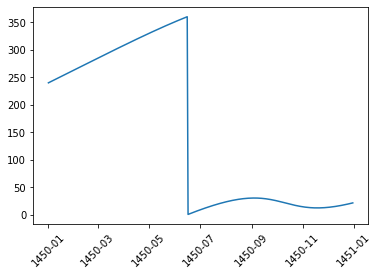

In [255]:
fig,ax = plt.subplots()

cond = [True]*len(mars.df)
ax.plot(mars.df[cond].datetime_proleptic,mars.df[cond].LonEpoch)
ax.tick_params(axis='x',rotation=45)

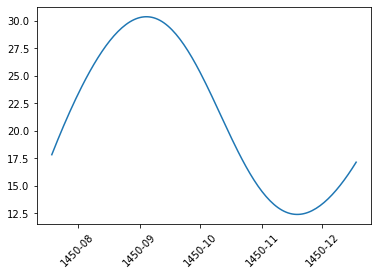

In [257]:
fig,ax = plt.subplots()

cond = (mars.df.datetime_mixed >= datetime(1450,8,1)) & (mars.df.datetime_mixed <= datetime(1450,12,31))

ax.plot(mars.df[cond].datetime_proleptic,mars.df.loc[cond,'LonEpoch'])
ax.tick_params(axis='x',rotation=45)

In [258]:
import plotly.express as px
import plotly.graph_objects as go

In [259]:
fig = px.scatter(mars.df,x='datetime_proleptic',y=['LonJ2000'])
fig.update_xaxes(rangeslider_visible=True)

In [252]:
mtime = MonTime('-1450-09-04 00:00:00.0')
print(mtime)

Montu Time Object:
--------------------------
General:
    Calendar: proleptic
    Is bce: True
    Components UTC: [-1, 1450, 9, 4, 0, 0, 0, 0]
Uniform scales:
    Delta-t = TT - UTC = 34197.280000000006
    Terrestrial time:
        tt: -108850185002.72
        jtd: 1191704.8958018518
    UTC time:
        et: -108850219200.0
        jed: 1191704.5
Strings:
    Date in native format: -1450-09-04 00:00:00.0
    Date in SPICE format: 1451 B.C. 09-04 00:00:00.000000
    Date in mixed calendar: -1450-09-17 00:00:00
Objects:
    Date in datetime64 format: -1450-09-04T00:00:00.000
    Date in datetime format proleptic: 1450-09-04 00:00:00
    Date in datetime format mixed: 1450-09-17 00:00:00
    Date in PyPlanet Epoch: 1191704.5
    Date in PyEphem Epoch: -1451/9/17 00:00:00
    Date in AstroPy Time: 1191704.8958018518
Astronomical properties at Epoch:
    True obliquity of ecliptic: 23:51:50.319
    True nutation longitude: 00:00:15.178
    Greenwhich Meridian Sidereal Time: 22:49:49.514

## Compute speed of motion

In [497]:
mars = PlanetaryBody('Mars')
mars.reset_store()

mtime_initial = MonTime('-1450-01-01 00:00:00.0')

dlondts = []
datetimes = []
for t in tqdm.tqdm(np.linspace(-3*365,3*365,500)):
    mtime = mtime_initial + t*DAY
    dlondts += [mars.ecliptic_longitude_advance(mtime,tebas,method='SPICE',dt=1*DAY)]
    datetimes += [t]


100%|██████████| 500/500 [00:02<00:00, 218.99it/s]


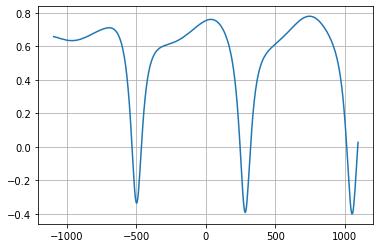

In [498]:
plt.plot(datetimes,dlondts)
plt.grid()

Find the minima close to a date:

In [493]:
mtime_initial = MonTime('50-01-01 00:00:00.0')
retrograde = lambda t:mars.ecliptic_longitude_advance(mtime_initial+t*DAY,tebas,method='SPICE',dt=1*HOUR)
min = minimize_scalar(retrograde,bounds=(0,2000),method='Bounded')
min

     fun: -0.42201926478554697
 message: 'Solution found.'
    nfev: 22
  status: 0
 success: True
       x: 705.7940023793592

In [546]:
mtime = MonTime(0*365,format='jd',scale='utc')
print(mtime)

Montu Time Object:
--------------------------
General:
    Calendar: proleptic
    Is bce: True
    Components UTC: [-1, 4713, 11, 24, 12, 0, 0, 0]
Uniform scales:
    Terrestrial time:
        tt: -211813351485.5232
        jtd: 1.5800286666666663
    UTC time:
        et: -211813488000.0
        jed: 0
    Delta-t = TT - UTC = 136514.47679999997
Strings:
    Date in SPICE format: 4714 B.C. 11-24 12:00:00.000000
    Date in proleptic calendar: -4713-11-24 12:00:00.0
    Date in proleptic calendar (jul.year): 0001-11-24 12:00:00.000000
    Date in mixed calendar: -4712-01-01 12:00:00
    Date in mixed calendar (jul.year): -0001-01-01 12:00:00
Objects:
    Date in datetime64 format: -4713-11-24T12:00:00.000
    Date in datetime format proleptic: 4713-11-24 12:00:00
    Date in datetime format proleptic (julian year): 0001-11-24 12:00:00
    Date in datetime format mixed: 4712-01-01 12:00:00
    Date in datetime format mixed (julian year): 0001-01-01 12:00:00
    Date in PyPlanet Epoch: 

In [523]:
mtime = MonTime('bce4714-11-24 12:00:00',scale='utc',calendar='proleptic')
print(mtime)

Montu Time Object:
--------------------------
General:
    Calendar: proleptic
    Is bce: True
    Components UTC: [-1, 4713, 11, 24, 12, 0, 41, 808000]
Uniform scales:
    Delta-t = TT - UTC = 136514.47679999997
    Terrestrial time:
        tt: -211813351443.7152
        jtd: 1.5805125553160906
    UTC time:
        et: -211813487958.19202
        jed: 0.00048388864942428
Strings:
    Date in native format: -4713-11-24 12:00:41.808000
    Date in SPICE format: 4714 B.C. 11-24 12:00:41.808000
    Date in mixed calendar: 0001-01-01 12:00:42
Objects:
    Date in datetime64 format: -4713-11-24T12:00:41.808000
    Date in datetime format proleptic: 4713-11-24 12:00:41.808000
    Date in datetime julian format proleptic: 0001-11-24 12:00:41.808000
    Date in datetime format mixed: 0001-01-01 12:00:42
    Date in PyPlanet Epoch: 0.00048388864942428
    Date in PyEphem Epoch: -4713/1/1 12:00:42
    Date in AstroPy Time: 1.5805125553160906
Astronomical properties at Epoch:
    True obliquit

In [506]:
datetime(1,1,1)

datetime.datetime(1, 1, 1, 0, 0)

In [538]:
mtime = MonTime('-2500-01-01 12:00:00.00',scale='utc')
print(mtime)

Montu Time Object:
--------------------------
General:
    Calendar: proleptic
    Is bce: True
    Components UTC: [-1, 2500, 1, 1, 12, 0, 0, 0]
Uniform scales:
    Delta-t = TT - UTC = 59699.68000000001
    Terrestrial time:
        tt: -142006202700.32
        jtd: 807954.6909685184
    UTC time:
        et: -142006262400.0
        jed: 807953.9999999999
Strings:
    Date in native format: -2500-01-01 12:00:00.0
    Date in SPICE format: 2501 B.C. 01-01 12:00:00.000000
    Date in mixed calendar (jul.year): 2214-01-01 12:00:00.000000
    Date in mixed calendar: -2500-01-22 12:00:00
Objects:
    Date in datetime64 format: -2500-01-01T12:00:00.000
    Date in datetime format proleptic: 2500-01-01 12:00:00
    Date in datetime format proleptic (julian year): 2214-01-01 12:00:00
    Date in datetime format mixed: 2500-01-22 12:00:00
    Date in PyPlanet Epoch: 807953.9999999999
    Date in PyEphem Epoch: -2501/1/22 12:00:00
    Date in AstroPy Time: 807954.6909685184
Astronomical proper

## Distances and magnitudes

In [112]:
from montu import *
earth = PlanetaryBody('Earth')
tebas = ObservingSite(planet=earth,lon=33,lat=24,height=0)
mtime = MonTime('bce1501-01-01 12:00:00')
mars = PlanetaryBody('Mars')
mars.calculate_sky_position(mtime,tebas,method='all',store=1)

Computing position of body 'mars' at epoch: jtd = 1173197.4080055554 
Updating orientation of site (old time 2000-01-01 11:58:56.126200, new time 1501 B.C. 01-01 12:00:00.000000)
We need distances and magnitudes
Method 'Horizons':
	Position Epoch:  -1500-01-01 12:00:00.0 1173196.9999999998
	Coordinates @ J2000: 
		Equatorial: 02:09:6.062 13:14:18.024
		Ecliptic: 34:36:39.045 00:11:29.358
	Coordinates @ Epoch : 
		Equatorial: 23:09:0.199 -5:37:56.352
		Ecliptic: 346:04:51.896 00:03:2.511
	Observing conditions: 
		Distance to site [au]:  1.7233433942796
		Distance to sun [au]:  1.5570528373
		Solar elongation [deg]:  63:26:27.240
		Phase angle [deg]:  34:40:41.880
		Magnitude:  0.9
	Other properties: 
		Local true sidereal time:  20:54:22.784
		Hour angle @ Epoch:  21:45:22.597
		Local coordinates @ Epoch:  127:43:13.948 45:47:35.642
Method 'VSOP87':
	Position Epoch:  -1500-01-01 12:00:00.0 1173196.9999999998
	Coordinates @ J2000: 
		Equatorial: 02:09:4.244 13:14:14.481
		Ecliptic: 34:36

In [114]:
mars.df.columns

Index(['datetime64', 'tt', 'jtd', 'jed', 'RAJ2000', 'DecJ2000', 'RAEpoch',
       'DecEpoch', 'LonJ2000', 'LatJ2000', 'LonEpoch', 'LatEpoch', 'tsa', 'HA',
       'az', 'el', 'site_distance', 'sun_distance', 'elongation', 'phase',
       'mag', 'RAJ2000_Horizons', 'DecJ2000_Horizons', 'RAEpoch_Horizons',
       'DecEpoch_Horizons', 'LonJ2000_Horizons', 'LatJ2000_Horizons',
       'LonEpoch_Horizons', 'LatEpoch_Horizons', 'tsa_Horizons', 'HA_Horizons',
       'az_Horizons', 'el_Horizons', 'site_distance_Horizons',
       'sun_distance_Horizons', 'elongation_Horizons', 'phase_Horizons',
       'mag_Horizons', 'RAJ2000_VSOP87', 'DecJ2000_VSOP87', 'RAEpoch_VSOP87',
       'DecEpoch_VSOP87', 'LonJ2000_VSOP87', 'LatJ2000_VSOP87',
       'LonEpoch_VSOP87', 'LatEpoch_VSOP87', 'tsa_VSOP87', 'HA_VSOP87',
       'az_VSOP87', 'el_VSOP87', 'site_distance_VSOP87', 'sun_distance_VSOP87',
       'elongation_VSOP87', 'phase_VSOP87', 'mag_VSOP87', 'RAJ2000_SPICE',
       'DecJ2000_SPICE', 'RAEpoch_SPICE'

In [102]:
mars.pyplanet.magnitude(mars.sundistance,
                        mars.distance,
                        pyplanets_Angle(mars.phase))

TypeError: magnitude() missing 1 required positional argument: 'phase_angle'

In [103]:
from pymeeus.Mars import Mars

In [107]:
Mars.magnitude(mars.sundistance,mars.distance,mars.phase*DEG)

-1.1

In [21]:
mars.ephemerides.columns

Index(['targetname', 'datetime_str', 'datetime_jd', 'solar_presence', 'flags',
       'RA', 'DEC', 'RA_app', 'DEC_app', 'RA_rate', 'DEC_rate', 'AZ', 'EL',
       'AZ_rate', 'EL_rate', 'sat_X', 'sat_Y', 'sat_PANG', 'siderealtime',
       'airmass', 'magextinct', 'V', 'surfbright', 'illumination',
       'illum_defect', 'sat_sep', 'sat_vis', 'ang_width', 'PDObsLon',
       'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang', 'SubSol_dist',
       'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r', 'r_rate', 'delta',
       'delta_rate', 'lighttime', 'vel_sun', 'vel_obs', 'elong', 'elongFlag',
       'alpha', 'lunar_elong', 'lunar_illum', 'sat_alpha', 'sunTargetPA',
       'velocityPA', 'OrbPlaneAng', 'constellation', 'TDB-UT', 'ObsEclLon',
       'ObsEclLat', 'NPole_RA', 'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime',
       'earth_lighttime', 'RA_3sigma', 'DEC_3sigma', 'SMAA_3sigma',
       'SMIA_3sigma', 'Theta_3sigma', 'Area_3sigma', 'RSS_3sigma', 'r_3sigma',
       'r_rate_3sigma', 'SBand

In [91]:
mars.ephemerides.illumination

0    <NA>
Name: illumination, dtype: Int64

In [36]:
import astropy.constants as astropy_const

In [40]:
astropy_const.c

<<class 'astropy.constants.codata2018.CODATA2018'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2018'>

In [44]:
mars.ephemerides.earth_lighttime*DAY*astropy_const.c.value/1e3/AU

0    0.06129319996668109
Name: earth_lighttime, dtype: float64

In [57]:
mars.ephemerides.alpha

0    13.37579999999999991
Name: alpha, dtype: float64

In [58]:
mars.ephemerides.alpha_true

0    13.37079999999999913
Name: alpha_true, dtype: float64

In [62]:
mars.ephemerides.elong

0    157.79750000000001364
Name: elong, dtype: float64

In [61]:
mars.ephemerides.columns

Index(['targetname', 'datetime_str', 'datetime_jd', 'solar_presence', 'flags',
       'RA', 'DEC', 'RA_app', 'DEC_app', 'RA_rate', 'DEC_rate', 'AZ', 'EL',
       'AZ_rate', 'EL_rate', 'sat_X', 'sat_Y', 'sat_PANG', 'siderealtime',
       'airmass', 'magextinct', 'V', 'surfbright', 'illumination',
       'illum_defect', 'sat_sep', 'sat_vis', 'ang_width', 'PDObsLon',
       'PDObsLat', 'PDSunLon', 'PDSunLat', 'SubSol_ang', 'SubSol_dist',
       'NPole_ang', 'NPole_dist', 'EclLon', 'EclLat', 'r', 'r_rate', 'delta',
       'delta_rate', 'lighttime', 'vel_sun', 'vel_obs', 'elong', 'elongFlag',
       'alpha', 'lunar_elong', 'lunar_illum', 'sat_alpha', 'sunTargetPA',
       'velocityPA', 'OrbPlaneAng', 'constellation', 'TDB-UT', 'ObsEclLon',
       'ObsEclLat', 'NPole_RA', 'NPole_DEC', 'GlxLon', 'GlxLat', 'solartime',
       'earth_lighttime', 'RA_3sigma', 'DEC_3sigma', 'SMAA_3sigma',
       'SMIA_3sigma', 'Theta_3sigma', 'Area_3sigma', 'RSS_3sigma', 'r_3sigma',
       'r_rate_3sigma', 'SBand

In [92]:
mars.pyephem_planet.mag

-1.13

In [27]:
mars.pyephem_planet.compute(mars.pyephem_site)


In [28]:
mars.pyephem_planet.earth_distance

0.6604883074760437

In [84]:
mars.pyephem_planet.mag

-1.13

In [66]:
mars.pyephem_planet.elong*RAD

-157.818359375

In [65]:
mars.pyephem_planet?

Type:        Mars
String form: <Mars "Mars" at 0x7f842b971040>
File:        ~/opt/anaconda3/lib/python3.9/site-packages/ephem/__init__.py
Docstring:   Create a Body instance representing Mars


In [51]:
mars.pyephem_planet.hlong

1.9418296813964844

In [56]:
mars.pyephem_planet.dec*RAD

24.111366696769647

In [73]:
mars.pyephem_planet.phase

98.64616394042969

In [95]:
mars.pyephem_planet.sun_distance

1.626107096672058

In [96]:
mars.ephemerides.r

0    1.62612486672299994
Name: r, dtype: float64

In [93]:
pyephem.Planet.mag?21




Type:        getset_descriptor
String form: <attribute 'mag' of 'ephem.Body' objects>
Docstring:   magnitude


In [94]:
pyplanets_Mars.magnitude?

Signature: pyplanets_Mars.magnitude(self, sun_dist, earth_dist, phase_angle) -> float
Docstring:
This function computes the approximate magnitude of Mars.

:param sun_dist: Distance from Mars to the Sun, in Astronomical Units
:type sun_dist: float
:param earth_dist: Distance from Mars to Earth, in Astronomical Units
:type earth_dist: float
:param phase_angle: Mars phase angle
:type phase_angle: float, :py:class:`Angle`

:returns: Mars' magnitude
:rtype: float
File:      ~/opt/anaconda3/lib/python3.9/site-packages/pyplanets/planets/mars.py
Type:      function


In [97]:
mars.pyephem_planet.mag

-1.13

## Algorithm to calculate station in longitude for mars

In [ ]:
marstices = pd.DataFrame()
i = 0

# Range of years
initial_year = -2000
final_year = -70

mars.reset_store()
mtime = MonTime(f'{initial_year}-01-01 00:00:00.00',scale='utc',calendar='proleptic')
i=0
while True:
    epoch1 = Mars(mtime.obj_pyplanet).station_longitude_1()
    epoch2 = Mars(mtime.obj_pyplanet).station_longitude_2()
    print(mtime.obj_pyplanet.year(),epoch1,epoch2)
    mtime1 = MonTime(float(epoch1),format='jd',calendar='mixed')
    mtime2 = MonTime(float(epoch2),format='jd',calendar='mixed')

    mtime = mtime + 2*YEAR
    i+=1
    if i>10:break

-1999.9535519125684 990473.0365413779 990551.5847383336
-1997.9547929704718 991237.9500486348 991318.5404239997
-1995.9535488216961 992003.6864322815 992083.8105434901
-1993.9547898727549 992775.5512183867 992852.2389160669
-1991.9535457340617 993563.4193280826 993631.2026313848
-1989.954786778285 994372.682377654 994433.6022621093
-1987.9535426496661 995164.5984547004 995235.2379030539
-1985.9547836870624 995937.6887916481 996014.7479095068
-1983.9535395685084 996703.6491770019 996783.6262110925
-1981.9547805990867 997468.3761049401 997548.9350165927
-1979.953536490589 997468.3761049401 997548.9350165927


In [ ]:
marstices = pd.DataFrame()
i = 0

# Range of years
initial_year = -2000
final_year = -70

mars.reset_store()
mtime = MonTime(f'{initial_year}-01-01 00:00:00.00',scale='utc',calendar='proleptic')
i=0
while True:
    epoch1 = Extra.station_longitude_1(mtime.year)
    epoch2 = Extra.station_longitude_2(mtime.year)
    print(mtime.obj_pyplanet.year(),epoch1,epoch2)
    mtime1 = MonTime(float(epoch1),format='jd',calendar='mixed')
    mtime2 = MonTime(float(epoch2),format='jd',calendar='mixed')

    mtime = mtime + 2*YEAR
    i+=1
    if i>10:break

-1999.9535519125684 990473.0365413779 990551.5847383336
-1997.9547929704718 991237.9500486348 991318.5404239997
-1995.9535488216961 992003.6864322815 992083.8105434901
-1993.9547898727549 992003.6864322815 992083.8105434901
-1991.9535457340617 993563.4193280826 993631.2026313848
-1989.954786778285 993563.4193280826 993631.2026313848
-1987.9535426496661 995164.5984547004 995235.2379030539
-1985.9547836870624 995164.5984547004 995235.2379030539
-1983.9535395685084 996703.6491770019 996783.6262110925
-1981.9547805990867 996703.6491770019 996783.6262110925
-1979.953536490589 997468.3761049401 997548.9350165927


In [ ]:
mtime.jed

998610.0062072593

In [ ]:
epoch1,epoch2,mtime1.datestr,mtime2.datestr

(Epoch(997468.3761049401),
 Epoch(997548.9350165927),
 '-1982-11-15 21:01:35.466800',
 '-1981-02-04 10:26:25.433600')

In [ ]:
station_longitude_1(-1979.953536490589),station_longitude_2(-1979.953536490589)

(997468.3761049401, 997548.9350165927)

In [ ]:
jde

-3000


625464.8061463411

## Montu Algorithm

We will develop an algorithm to find station in longitude.

First define a routine to show the advance in longitude for the planet:

In [ ]:
def plot_station(planet,jde,dt=1,npoints=50):

    mtime_initial = MonTime(jde,format='jd')
    dlondts = []
    lons = []
    datetimes = []
    for t in np.linspace(-dt*365,dt*365,npoints):
        mtime = mtime_initial + t*DAY
        planet.calculate_sky_position(mtime,tebas,verbose=0,store=0)
        dlondts += [mars.ecliptic_longitude_advance(mtime,tebas,method='SPICE',dt=1*DAY)]
        lons += [planet.LonEpoch] 
        datetimes += [mtime.jed]

    fig,axs = plt.subplots(2,1,sharex=True)

    ax = axs[0]
    ax.plot(datetimes,dlondts)
    ax.axvline(jde,color='r')
    ax.grid()

    ax = axs[1]
    ax.plot(datetimes,lons)
    ax.axvline(jde,color='r')
    ax.grid()

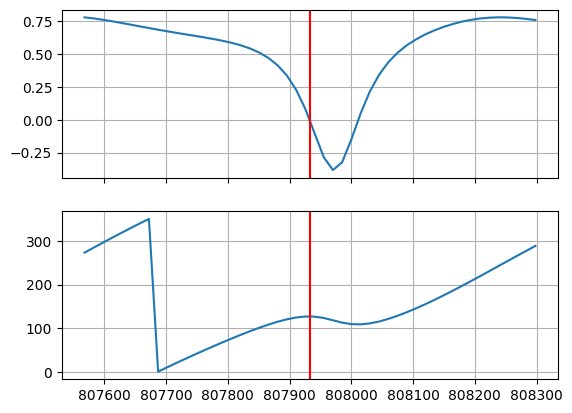

In [ ]:
from montu import *

jde = station_longitude_1(-2500)
mars = PlanetaryBody('Mars')

plot_station(mars,jde)

(990209.4999999999, 990551.5847383336)

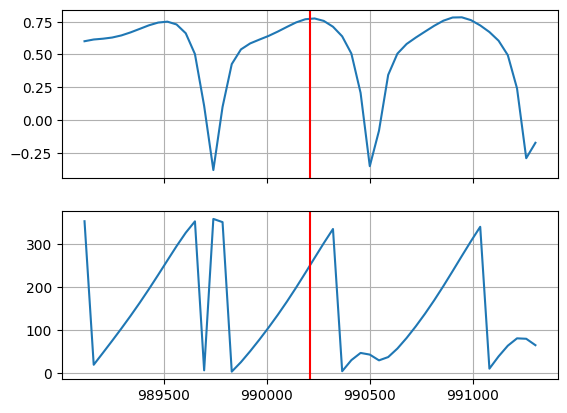

In [ ]:
mtime = MonTime('-2001-01-01 00:00:00.00')
plot_station(mars,mtime.jed,dt=3)
mtime.jed, station_longitude_2(mtime.year)

In [ ]:
def ecliptic_longitude(t):
    mars.calculate_sky_position(mtime+t*DAY,tebas,verbose=0,store=0)
    return mars.LonEpoch

In [ ]:
min=minimize_scalar(ecliptic_longitude)
min.x

-387.8175923002247

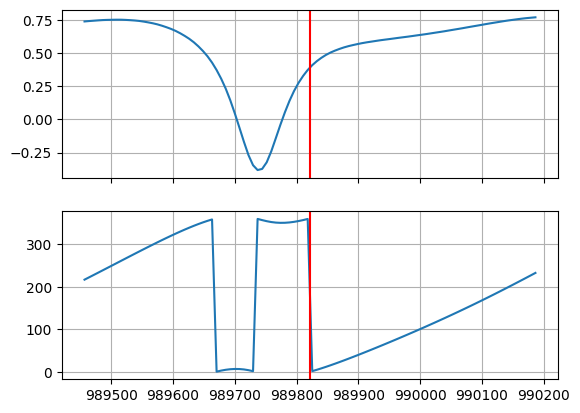

In [ ]:
plot_station(mars,(mtime+min.x*DAY).jed,npoints=100)

In [ ]:
retrograde = lambda t:mars.ecliptic_longitude_advance(mtime+t*DAY,tebas,method='SPICE',dt=1*HOUR)

In [ ]:
newton(retrograde,0)

ValueError: year 53191 is out of range

In [ ]:
bisect(retrograde,0,100)

ValueError: f(a) and f(b) must have different signs

In [ ]:
from scipy.optimize import newton,minimize_scalar,bisect

In [ ]:
min = minimize_scalar(retrograde,bounds=(0,2000),method='Bounded')
min

     fun: -0.41806554236882226
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 700.363640665241

In [ ]:
min = minimize_scalar(retrograde,bounds=(-50,0),method='Bounded')
min

     fun: -0.31952267484200547
 message: 'Solution found.'
    nfev: 16
  status: 0
 success: True
       x: -46.720785832768534

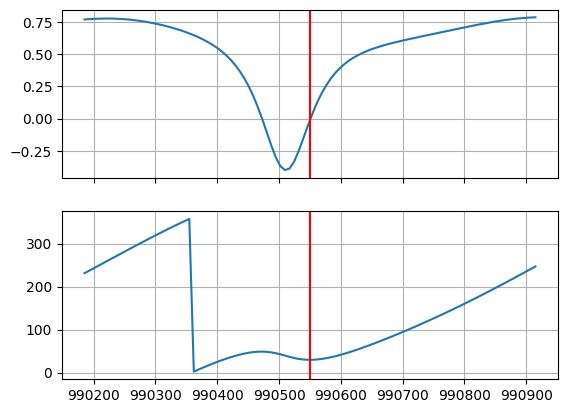

In [ ]:
plot_station(mars,(mtime-24.393896157742745*DAY).jed,npoints=100)